In [73]:
!pip install seaborn
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
nc_files = sorted(glob.glob("C:/Users/aneli/Documents/LOC/PC_casa/Dataset/**/*.nc", recursive=True))

In [75]:
def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds
    
def check_staircase_exists(ml_h, gl_h): #verifica se os valores são fisicamente válidos (n só se existem)

    valid_ml = np.sum(~np.isnan(ml_h) & (ml_h > 0))
    valid_gl = np.sum(~np.isnan(gl_h) & (gl_h > 0))

    return (valid_ml >= 1) and (valid_gl >= 1)
    
def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim] #p n ter problema d confundir "n" e "Nobs"

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        # SALT FINGER
        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        gl_mask_sf = ds.mask_gl_sf_layer.isel({profile_dim: i}) > 0

        ml_h_sf = ds.ml_h.isel({profile_dim: i}).values[ml_mask_sf.values] #pega os valores onde ml_mask_sf é True 
        gl_h_sf = ds.gl_h.isel({profile_dim: i}).values[gl_mask_sf.values]

        if len(ml_h_sf) > 0 and len(gl_h_sf) > 0:
            staircase_sf[i] = check_staircase_exists(
                ml_h_sf, gl_h_sf
            )

        # DIFFUSIVE CONVECTION
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0
        gl_mask_dc = ds.mask_gl_dc_layer.isel({profile_dim: i}) > 0

        ml_h_dc = ds.ml_h.isel({profile_dim: i}).values[ml_mask_dc.values]
        gl_h_dc = ds.gl_h.isel({profile_dim: i}).values[gl_mask_dc.values]

        if len(ml_h_dc) > 0 and len(gl_h_dc) > 0:
            staircase_dc[i] = check_staircase_exists(
                ml_h_dc, gl_h_dc
            )

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds
    
def boxplot_duplo(df_puro, df_total, var, ylabel, invert_y=False):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Limites globais

    ymin = min(df_puro[var].min(), df_total[var].min())
    ymax = max(df_puro[var].max(), df_total[var].max())

    # PUROS + MISTO

    sns.boxplot(
        data=df_puro,
        x="regime",
        y=var,
        order=["DC", "SF", "MISTO"],
        ax=axes[0],
        showfliers=False,          
        color="lightgray" 
    )

    axes[0].set_title(f"{ylabel} - Puros e Mistos")
    axes[0].set_xlabel("")
    axes[0].set_ylabel(ylabel)

    # TOTAIS

    sns.boxplot(
        data=df_total,
        x="regime_plot",
        y=var,
        order=["DC_TOTAL", "SF_TOTAL", "GERAL"],
        ax=axes[1],
        showfliers=False,          
        color="lightgray"
    )

    axes[1].set_title(f"{ylabel} - Totais")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    # Ajustar escala

    axes[1].set_ylim(axes[0].get_ylim())

    if invert_y:
        axes[0].invert_yaxis()
        axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [76]:
# LISTAS ACUMULADORAS
ml_puro = []
gl_puro = []

ml_total = []
gl_total = []

n_perfis = 0

for file in nc_files:

    ds = xr.open_dataset(file)

    #Recorte regional
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        ds.close()
        continue

    #Detectar staircases
    ds = detect_staircases(ds)

    n_profiles = ds.sizes["Nobs"]

    for i in range(n_profiles):

        lat = ds.lat.values[i]

        sf_profile = bool(ds.staircase_sf.values[i])
        dc_profile = bool(ds.staircase_dc.values[i])

        if not (sf_profile or dc_profile):
            continue

        n_perfis += 1

        mixed_profile = sf_profile and dc_profile
        sf_only = sf_profile and not dc_profile
        dc_only = dc_profile and not sf_profile

        #TOTAL (tudo que é SF ou DC independente de pureza)
        mask_sf_total = ds.mask_ml_sf_layer.values[i, :] > 0
        mask_dc_total = ds.mask_ml_dc_layer.values[i, :] > 0

        idx_total = np.where(mask_sf_total | mask_dc_total)[0]

        for j in idx_total:

            regime_total = (
                "SF_TOTAL" if mask_sf_total[j]
                else "DC_TOTAL"
            )

            ml_total.append({
                "regime": regime_total,
                "depth": ds.ml_p.values[i, j],
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })

        # Gradient total
        mask_sf_gl_total = ds.mask_gl_sf_layer.values[i, :] > 0
        mask_dc_gl_total = ds.mask_gl_dc_layer.values[i, :] > 0

        idx_gl_total = np.where(mask_sf_gl_total | mask_dc_gl_total)[0]

        for j in idx_gl_total:

            regime_total = (
                "SF_TOTAL" if mask_sf_gl_total[j]
                else "DC_TOTAL"
            )

            gl_total.append({
                "regime": regime_total,
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

        #PUROS E MISTO

        if mixed_profile:

            regime_name = "MISTO"
            mask_ml = mask_sf_total | mask_dc_total
            mask_gl = mask_sf_gl_total | mask_dc_gl_total

        elif sf_only:

            regime_name = "SF"
            mask_ml = mask_sf_total
            mask_gl = mask_sf_gl_total

        elif dc_only:

            regime_name = "DC"
            mask_ml = mask_dc_total
            mask_gl = mask_dc_gl_total

        else:
            continue

        # Mixed layers puros/misto
        idx_ml = np.where(mask_ml)[0]

        for j in idx_ml:
            ml_puro.append({
                "regime": regime_name,
                "depth": ds.ml_p.values[i, j],
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })

        # Gradient layers puros/misto
        idx_gl = np.where(mask_gl)[0]

        for j in idx_gl:
            gl_puro.append({
                "regime": regime_name,
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

    ds.close()

# CRIAR DATAFRAMES
df_ml_puro = pd.DataFrame(ml_puro).dropna()
df_gl_puro = pd.DataFrame(gl_puro).dropna()

df_ml_total = pd.DataFrame(ml_total).dropna()
df_gl_total = pd.DataFrame(gl_total).dropna()

# CRIAR BINS
df_ml_puro["depth_bin"] = pd.cut(
    df_ml_puro["depth"],
    bins=[0, 500, 1000, 1500, 2000],
    labels=["0-500", "500-1000", "1000-1500", "1500-2000"]
)

df_ml_puro["lat_bin"] = pd.cut(
    df_ml_puro["lat"],
    bins=np.arange(-60, 10, 10)
)

sns.set(style="whitegrid")

print("Perfis analisados:", n_perfis)
print("Camadas puras/mistas:", len(df_ml_puro))
print("Camadas totais:", len(df_ml_total))

Perfis analisados: 17468
Camadas puras/mistas: 101136
Camadas totais: 101151


In [77]:
# Criar GERAL para ML
df_ml_total["regime_plot"] = df_ml_total["regime"]
df_ml_total_geral = df_ml_total.copy()
df_ml_total_geral["regime_plot"] = "GERAL"

df_ml_total_plot = pd.concat([df_ml_total, df_ml_total_geral])

# Criar GERAL para GL

df_gl_total["regime_plot"] = df_gl_total["regime"]
df_gl_total_geral = df_gl_total.copy()
df_gl_total_geral["regime_plot"] = "GERAL"

df_gl_total_plot = pd.concat([df_gl_total, df_gl_total_geral])

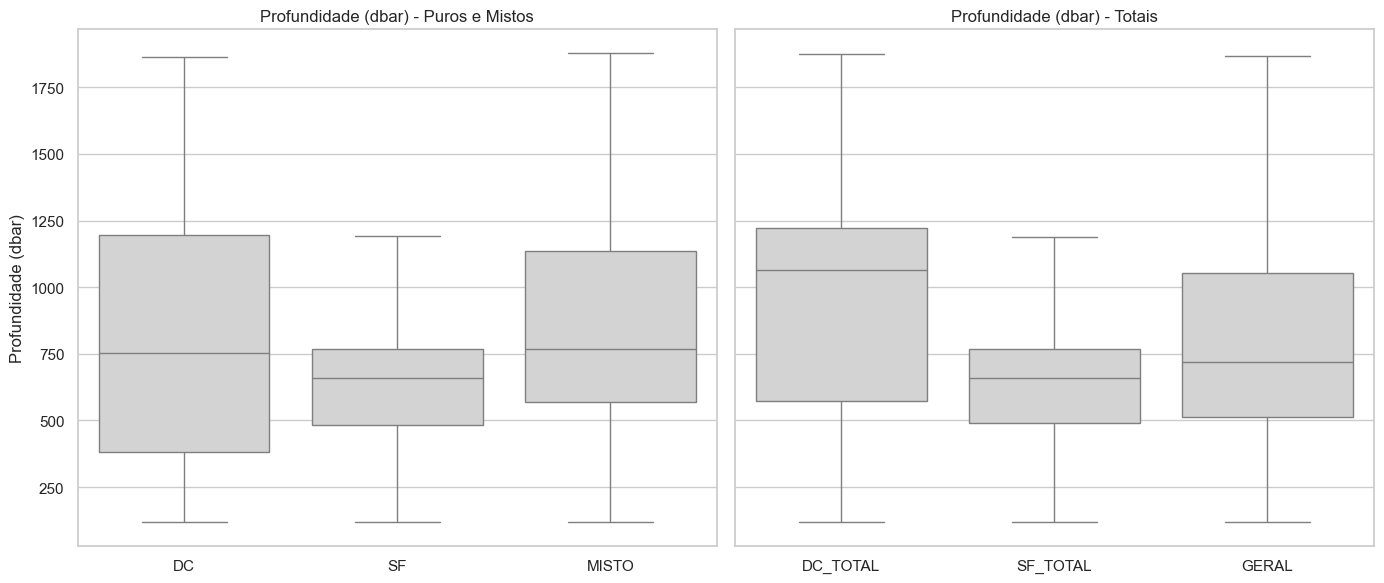

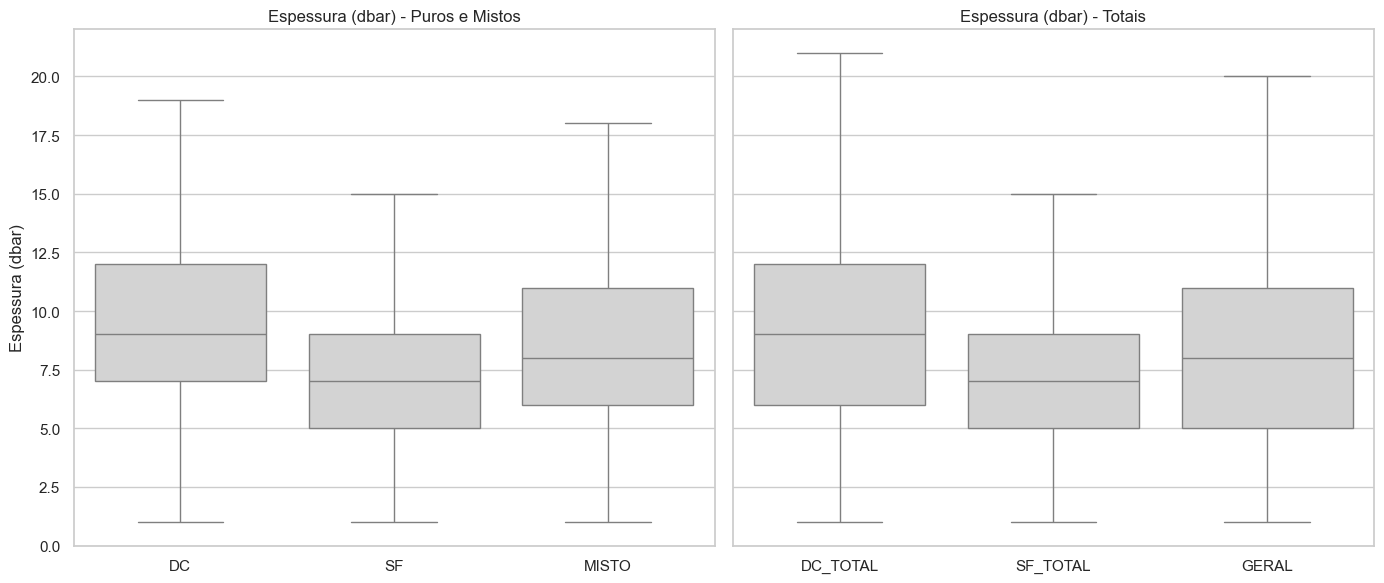

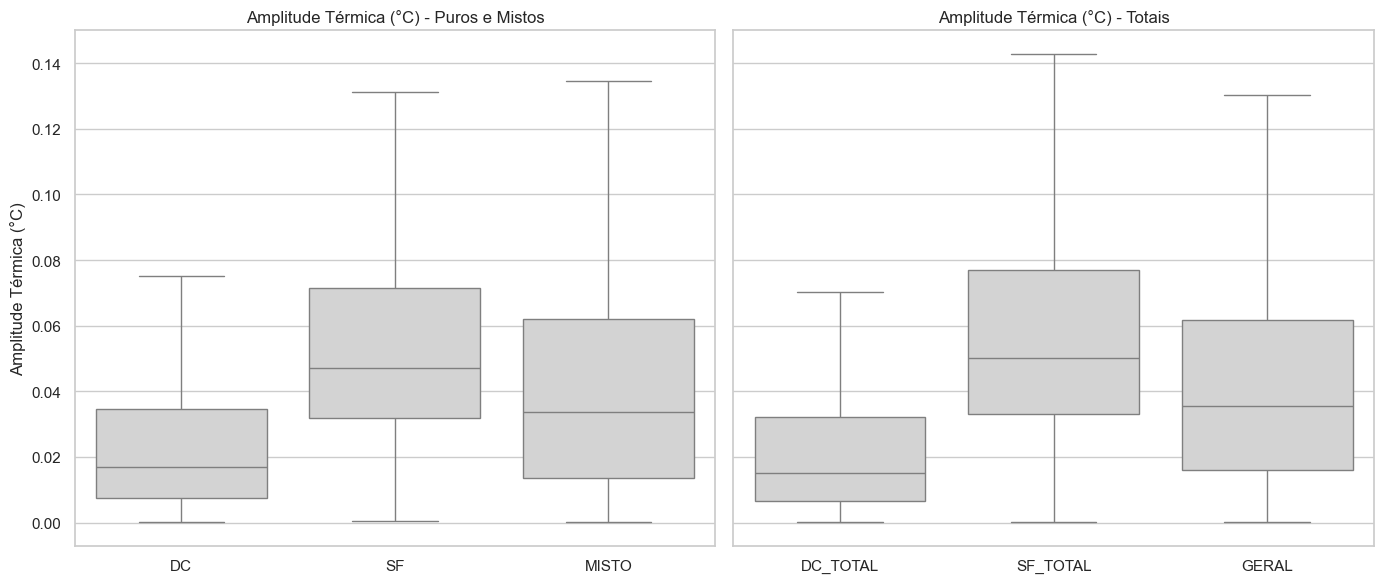

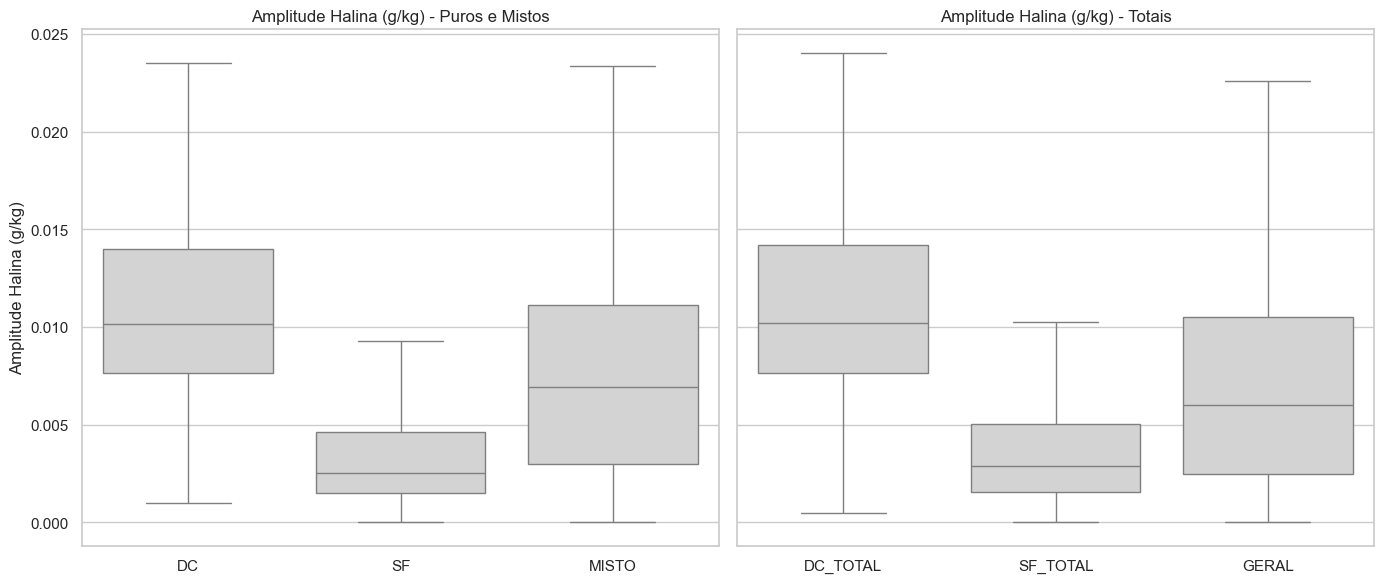

In [78]:
boxplot_duplo(
    df_ml_puro,
    df_ml_total_plot,
    var="depth",
    ylabel="Profundidade (dbar)",
    invert_y=True
)
boxplot_duplo(
    df_ml_puro,
    df_ml_total_plot,
    var="thickness",
    ylabel="Espessura (dbar)",
    invert_y=False
)
boxplot_duplo(
    df_gl_puro,
    df_gl_total_plot,
    var="dT",
    ylabel="Amplitude Térmica (°C)",
    invert_y=False
)
boxplot_duplo(
    df_gl_puro,
    df_gl_total_plot,
    var="dS",
    ylabel="Amplitude Halina (g/kg)",
    invert_y=False
)

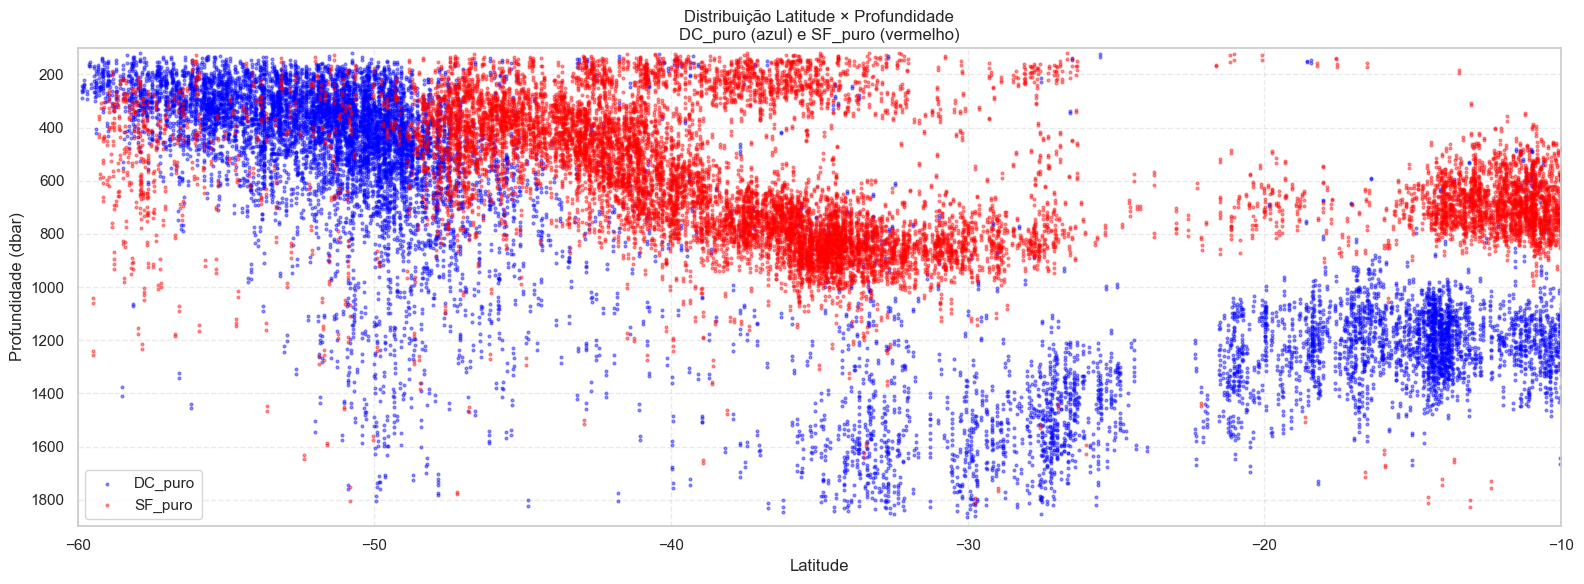

In [79]:
df_dc = df_ml_puro[df_ml_puro["regime"] == "DC"]
df_sf = df_ml_puro[df_ml_puro["regime"] == "SF"]

plt.figure(figsize=(16, 6))

plt.scatter(
    df_dc["lat"],
    df_dc["depth"],
    c="blue",
    s=4,
    alpha=0.4,
    label="DC_puro"
)

plt.scatter(
    df_sf["lat"],
    df_sf["depth"],
    c="red",
    s=4,
    alpha=0.4,
    label="SF_puro"
)

plt.xlim(-60, -10)
plt.ylim(100, 1900)

plt.gca().invert_yaxis()

plt.xlabel("Latitude")
plt.ylabel("Profundidade (dbar)")
plt.title("Distribuição Latitude × Profundidade\nDC_puro (azul) e SF_puro (vermelho)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [80]:
# PROCESSANDO APENAS CAMADAS DC E SF DE PERFIS MISTOS

ml_data_misto = []
gl_data_misto = []
n_perfis_mistos = 0

for file in nc_files:

    ds = xr.open_dataset(file)

    #Recorte regional
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        ds.close()
        continue

    #Detectar staircases
    ds = detect_staircases(ds)

    n_profiles = ds.sizes["Nobs"]

    for i in range(n_profiles):

        lat = ds.lat.values[i]

        # CLASSIFICAÇÃO DO PERFIL
        sf_profile = bool(ds.staircase_sf.values[i])
        dc_profile = bool(ds.staircase_dc.values[i])

        mixed_profile = sf_profile and dc_profile

        # apenas perfis mistos
        if not mixed_profile:
            continue

        n_perfis_mistos += 1

        # ML LAYERS (depth, thickness)

        # ---- SF dentro do perfil misto ----
        mask_sf = ds.mask_ml_sf_layer.values[i, :]
        idx_sf = np.where(mask_sf > 0)[0]

        for j in idx_sf:
            ml_data_misto.append({
                "regime": "SF_misto",
                "depth": ds.ml_p.values[i, j],
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })

        # ---- DC dentro do perfil misto ----
        mask_dc = ds.mask_ml_dc_layer.values[i, :]
        idx_dc = np.where(mask_dc > 0)[0]

        for j in idx_dc:
            ml_data_misto.append({
                "regime": "DC_misto",
                "depth": ds.ml_p.values[i, j],
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })

        # GL LAYERS (dT, dS) 

        # ---- SF gradient layers ----
        mask_sf_gl = ds.mask_gl_sf_layer.values[i, :]
        idx_sf_gl = np.where(mask_sf_gl > 0)[0]

        for j in idx_sf_gl:
            gl_data_misto.append({
                "regime": "SF_misto",
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

        # ---- DC gradient layers ----
        mask_dc_gl = ds.mask_gl_dc_layer.values[i, :]
        idx_dc_gl = np.where(mask_dc_gl > 0)[0]

        for j in idx_dc_gl:
            gl_data_misto.append({
                "regime": "DC_misto",
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

    ds.close()

# CRIAR DATAFRAMES

df_ml_misto = pd.DataFrame(ml_data_misto)
df_gl_misto = pd.DataFrame(gl_data_misto)

df_ml_misto = df_ml_misto.dropna()
df_gl_misto = df_gl_misto.dropna()

print("Perfis mistos:", n_perfis_mistos)
print("Camadas ML:", len(df_ml_misto))
print("Camadas GL:", len(df_gl_misto))

Perfis mistos: 6915
Camadas ML: 58279
Camadas GL: 30561


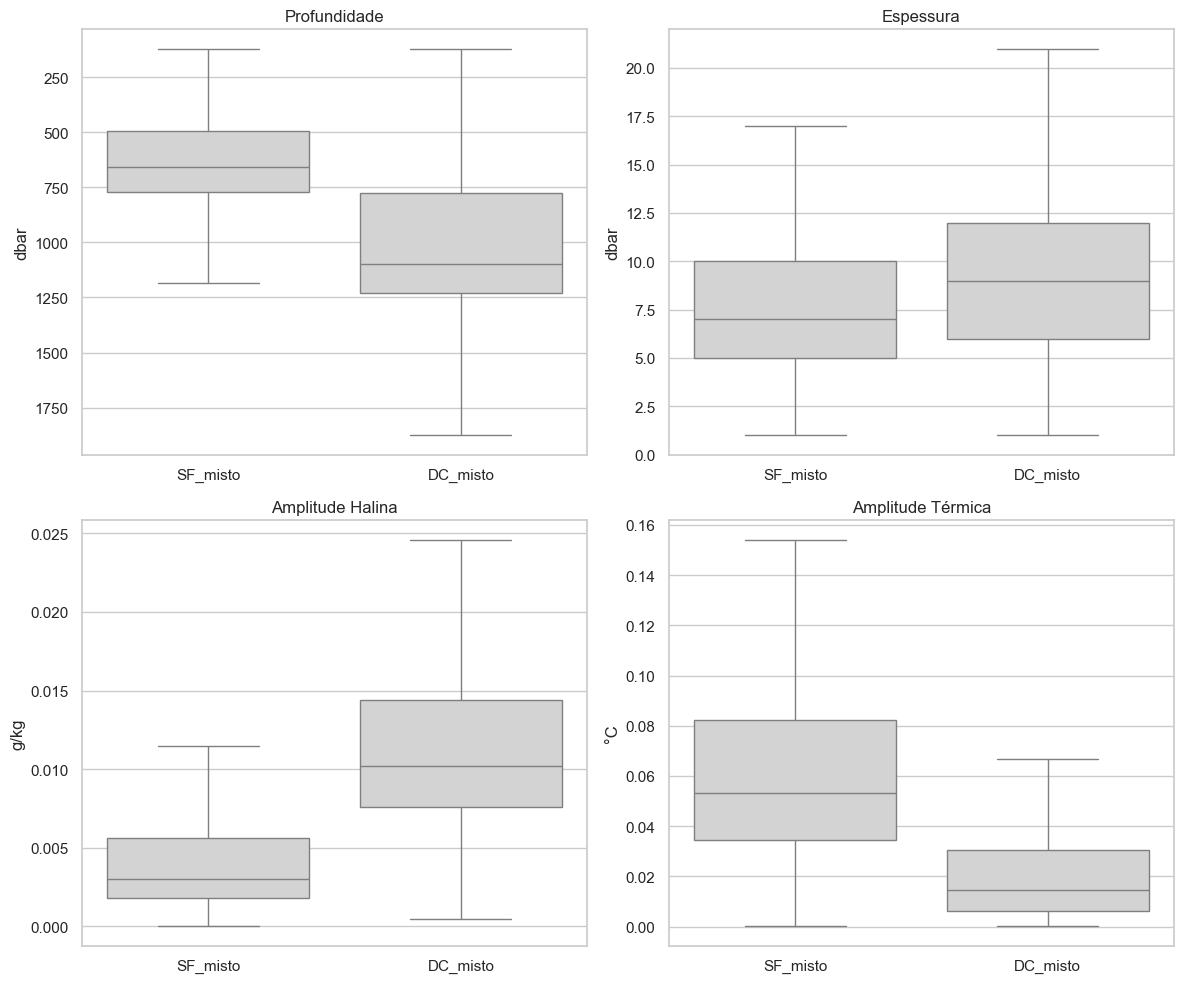

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) PROFUNDIDADE
sns.boxplot(
    data=df_ml_misto,
    x="regime",
    y="depth",
    showfliers=False,
    color="lightgray",
    ax=axes[0, 0]
)
axes[0, 0].invert_yaxis()
axes[0, 0].set_title("Profundidade")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("dbar")

# 2) ESPESSURA
sns.boxplot(
    data=df_ml_misto,
    x="regime",
    y="thickness",
    showfliers=False,
    color="lightgray",
    ax=axes[0, 1]
)
axes[0, 1].set_title("Espessura")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("dbar")

#AMPLITUDE HALINA
sns.boxplot(
    data=df_gl_misto,
    x="regime",
    y="dS",
    showfliers=False,
    color="lightgray",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Amplitude Halina")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("g/kg")

# AMPLITUDE TÉRMICA
sns.boxplot(
    data=df_gl_misto,
    x="regime",
    y="dT",
    showfliers=False,
    color="lightgray",
    ax=axes[1, 1]
)
axes[1, 1].set_title("Amplitude Térmica")
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("°C")

plt.tight_layout()
plt.show()